# **Objetivo de la Actividad**


> Trabajar con estos modelos pre-entrenados, generando el vocabulario a partir de tu conjunto de datos de entrenamiento.

Para cada palabra de tu vocabulario, podrás sustituirlo por su correspondiente
vector continuo. En caso de que no exista el vector para una palabra en particular, se puede eliminar dicha palabra, o bien sustituirla por el vector continuo más cercano.

En esta actividad deberás aplicar esta segunda opción.

-----

*   Existen diversas propuestas para utilizar dichos vectores continuos como entrada para modelos de aprendizaje automático. En particular, en esta actividad cada enunciado será sustituido por el vector promedio de todos los tokens que lo forman.

**Modelos:**

Modelo de vectores **continuos/embebidos FastText**, es decir, el modelo desarrollado por Facebook en 2016.

## **Pregunta 1**

Descarga los **3 archivos de Canvas**. En particular, el archivo de datos de **IMDb** ya no requiere transformarse **para obtener sus 1000 registros**. Al cargar los datos de los tres archivos deberás tener un **DataFrame de Pandas de 3000 registros**, con sus etiquetas. Los archivos los encuentras en Canvas y se llaman: **amazon5.txt, imdb5.txt, yelp5.txt.**

In [1]:
import pandas as pd
import numpy as np

import re
import string

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize

from nltk.stem import PorterStemmer, WordNetLemmatizer, RegexpStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Alberto
[nltk_data]     Patraca\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
# !gunzip cc.en.300.vec.gz

#**Aplicando NLTK**

In [3]:
nltk.download('punkt')        # Tokenizador que ayuda a dividr el texto en enunciados
nltk.download('stopwords')    # Acceso a "stopwords" en varios idiomas.

[nltk_data] Downloading package punkt to C:\Users\Alberto
[nltk_data]     Patraca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Alberto
[nltk_data]     Patraca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Lista de stopwords que se incluyen de manera predeterminada la suite de librerías de NLTK

print(len(stopwords.words('english')))
print(stopwords.words('english'))

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than

In [5]:
#Se extraen los archivos desde repositorio público de GitHub
url1 = 'https://raw.githubusercontent.com/Handrum/NLP_EQ_6/main/amazon5.txt'
url2 = 'https://raw.githubusercontent.com/Handrum/NLP_EQ_6/main/imdb5.txt'
url3 = 'https://raw.githubusercontent.com/Handrum/NLP_EQ_6/main/yelp5.txt'

#Se cargan los archivos en dataframe de Pandas
dfa5 = pd.read_csv(url1, sep='\t', names=['review','label'], header=None, encoding='utf-8')
dfi5 = pd.read_csv(url2, sep=' {3,4}', names=['review','label'], header=None, encoding='utf-8')
dfy5 = pd.read_csv(url3, sep='\t', names=['review','label'], header=None, encoding='utf-8')

#Se imprime la forma de los dataframes
print('Total de registros de Amazon_5:',dfa5.shape)
print('Total de registros de IMBD_5:',dfi5.shape)
print('Total de registros de Yelp_5:',dfy5.shape)

C:\Users\Alberto Patraca\AppData\Local\Temp\ipykernel_24532\3513401339.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dfi5 = pd.read_csv(url2, sep=' {3,4}', names=['review','label'], header=None, encoding='utf-8')


Total de registros de Amazon_5: (1000, 2)
Total de registros de IMBD_5: (1000, 2)
Total de registros de Yelp_5: (1000, 2)


In [6]:
dfi5.head()

,review,label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [7]:
#Concatenar los 3,000 registros

df = pd.concat([dfa5, dfi5, dfy5], ignore_index=True)
print('Numero de registros',df.shape)
df.info()

Numero de registros (3000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  3000 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


Al realizar la revisión del conjunto de datos se observa que el dataset de **imdb5** tiene 1.000 flotantes. Lo que requiere una limpieza especial para dicho dataset. --- **Sin embargo, se encontró que al cargar con el separador correcto, el siguiente paso no es necesario**.

In [8]:
X = df.review     # Serie de strings
Y = df.label      # Serie de enteros 0s y 1s

assert X.shape == (3000,)           # verificando que tenemos la dimensiones esperadas.
assert Y.shape == (3000,)

# **Pregunta 2**

Realiza de nuevo un proceso de limpieza. Aplica el preprocesamiento que consideres adecuado, sin embargo, deberás aplicar necesariamente alguna de las técnicas de lematización. Como aplicaremos modelos embebidos pre-entrenados, queremos palabras lo más cercanas a las existentes en un idioma, inglés en este caso. Aplica y justifica cualquier otro proceso de limpieza que consideres
adecuado. Recuerda que en esta actividad se usarán vectores embebidos para un problema de clasificación, por lo que deberás tomar de acuerdo a este contexto. Justifica todas las transformaciones que se apliquen.



**Procedimiento para quitar las negaciones del conjunto de stopwords en caso de ser necesario**

In [9]:
# Consideremos la siguiente lista de palabras asociada a negaciones en inglés:

mystopwords = stopwords.words('english')

negwords = [ 'no', 'nor', 'not', 'ain', 'aren', "aren't", 'don', "don't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

#Se asigna las stopwords de NLTK a mystopwords
mystopwords_without_neg = stopwords.words('english')

#Se revisa si cada una de las palabras en negwords está presente en mystopwords
for word in negwords:
    if word in mystopwords_without_neg:
      mystopwords_without_neg.remove(word)           # si la palabra está presente, quitarla de la lista

#Se imprime la longitud y elementos de negwords para verificar resultados
print(len(negwords))
print(negwords)

#Se imprime la longitud y elementos de los stop words de NLTK para verificar resultados
print(len(mystopwords))
print(mystopwords)

print(len(mystopwords_without_neg))
print(mystopwords_without_neg)

40
['no', 'nor', 'not', 'ain', 'aren', "aren't", 'don', "don't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about'

**NOTA**: Es importante tener en cuenta, que en el análisis de sentimientos debemos abarcar el vocabulario suficiente que nos permita entender la opinión del usuario y así mismo identificar aquellas opiniones que puden enriquecer y construir una interacción más amena con el cliente. Para ello, Se considera realizar una depuración de las negaciones que no agregan valor al resultado del diccionario que se requiere y que no definen a profundidad el sentimiento del cliente, estas se pueden ser reemplazadas por un vector continuo más cercano.

In [10]:
def clean_tok(doc):
    ##############################################################################
    # AGREGA AQUÍ TUS LÍNEAS DE CÓDIGO - Pregunta 4:
    
    # Eliminación de signos de puntuación, caracteres especiales.
    
    doc = doc.lower()    #normalización a minúsculas
    
    #Sólo caracteres alfabéticos
    puntuacion = re.sub(r'[^a-z]', ' ', doc)                  #considerar solo caracteres alfabéticos
    puntuacion = re.sub(r'\s{2, }', ' ', puntuacion.strip())  #eliminar todo tipo de espacios que se encuentren
    
    # Tokenizar
    tokenizar = puntuacion.split()                            #tomar el resultado anterior y aplicar método de tokenización a partir del método split
    
    # Eliminación de Stopwords
    
    tokens = [token for token in tokenizar if (token not in mystopwords and len(token) >1)]  #en esta ocasión para elimianr los stopwords se toma la librería de corpus el mismo método.
    
    # FIN PARA AGREGAR TUS LÍNEAS DE CÓDIGO.
    ##############################################################################
    
    return tokens

Se hizo la transformación a minúsculas de cada comentario. Posteriormente, se eliminaron los caractéres que no corresponden al afabeto, es decir, cualquier signo de puntuacíon o número, estos se convertían a espacios en blanco " "; dejando únicamente las letras de la a la la z en el abecedario inglés (sin ñ).
Posteriormente, si en algún lugar quedaba más de un espacio en blanco " " seguido, se reducía a únicamente uno.
Finalmente, se separaban los tokens de cada comentario, y se eliminaban los tokens que se encontraran en la lista "mystopwords" y/o tuvieran solo 1 caracter.


In [11]:
Xcleantok = [clean_tok(x) for x in X]

In [12]:
df.head()

,review,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [13]:
for x in Xcleantok[0:5]:
    print(x)

['way', 'plug', 'us', 'unless', 'go', 'converter']
['good', 'case', 'excellent', 'value']
['great', 'jawbone']
['tied', 'charger', 'conversations', 'lasting', 'minutes', 'major', 'problems']
['mic', 'great']


# **Método Limpieza por Lematizazión**

In [14]:
#lista vacía para análisis visual
palabras = []

#ciclo para juntar todos los tokens previos en una lista
for tokens1 in Xcleantok:

  palabras.extend(tokens1)

#Set para eliminar repeticiones
dic = set(palabras)

#Imprimir resultados para análisis visual
#print(sorted(dic))


#Se crea un objeto de la clase PorterStemmer
#ps = PorterStemmer() #Se requiere usar lematización para utilizar el método de vectores embebidos

#Se crea un objeto de la clase WordNetLemmatizer
WNL = WordNetLemmatizer()

#Definición de la función de limpieza adicional
def clean_doc(doc):

    #Se define lista vacía para los nuevos tokens
    # tokens = stemmer_tokens(doc)
    clean_tokens = []
    
    #Ciclo para la limpieza de los tokens
    for token in doc:

        no_dups_token = re.sub(r'([a-z])\1{2,}', r'\1\1', token) 
        # Se aplica un filtro con regex para eliminar palabras donde se repita más de 2 veces seguidas la misma letra

        
        if len(no_dups_token) == 2 and no_dups_token.endswith('s'):
            # Se aplica un filtro para las palabras como "as", "is", y "us", que no se les elimine la "s" final por la lematización
            clean_tokens.append(no_dups_token)
            continue
        elif len(no_dups_token) == 3 and no_dups_token.endswith('ed'):
            # Se aplica un filtro para las palabras como "ted", "fed", y "ned", que no se les eliminen las "ed" finales por la lematización
            clean_tokens.append(no_dups_token)
            continue
        elif len(no_dups_token) == 4 and no_dups_token.endswith('ing'):
            # Se aplica un filtro para las palabras como "ping", "bing", y "ring", que no se les eliminen las "ing" finales por la lematización
            clean_tokens.append(no_dups_token)
            continue
            
        #Se aplica stemming lo cual nos llevará las palabras a su base, incluyendo remover las terminaciones 'ing','ed','s'
        #doc[j] = ps.stem(doc[j]) #Se aplica lematización en lugar de stemming
    
        #Sólo lematizar tokens mas de más de dos caracteres
        if len(no_dups_token) < 2:
            continue
    
        #Se intenta lematizar verbo
        lem_token = WNL.lemmatize(no_dups_token,'v')
        
        #Si el token permanece sin cambios, intentar lematizar como sustantivo
        if lem_token == no_dups_token:
            lem_token = WNL.lemmatize(no_dups_token, 'n')
        
        #Si el token permanece sin cambios, intentar lematizar como adjetivo
        if lem_token == no_dups_token:
            lem_token = WNL.lemmatize(no_dups_token,'a')
        
        #Si el token permanece sin cambios, intentar lematizar como advervio
        if lem_token == no_dups_token:
            lem_token = WNL.lemmatize(no_dups_token,'r')
        
        #Agregar el resultado a la lista de tokens límpios (clean_tokens)
        clean_tokens.append(lem_token)

    return clean_tokens

Aquí primero se redujeron las letras que pudieran estar repetidas más de 2 veces seguidas en una misma palabra, por ejemplo, en "doctorrr", la "r" se repite 3 veces seguidas, por lo que nuestro primer paso de limpieza la reduce a únicamente 2, ya que en el idioma inglés, no existe ninguna palabra que tenga una misma letra repetida más de 2 veces continuas.
Seguido de eso, se incluyeron condiciones que protegieran palabras de 2 letras que terminaran en "s", de 3 letras que terminaran en "ed" y de 4 letras que terminaran en "ing", ya que la lematización podía transformarlas de maneras inadecuadas.
Finalmente, se aplicaba lematización a los tokens previos, en orden de verbo, sustantivo, adjetivo y advervio. La lematización se aplico debido a que hay varias palabras como "playing" o "played" que tienen la misma base "play" y cuya diferenciación, en términos de procesamiento de lenguaje es inservible, nos funciona más definirlas en una misma, tal como "play".
Aquí culmina nuestra limpieza.

In [15]:
# Aplicamos el proceso de limpieza/normalización adicionales:

Xclean = [clean_doc(x) for x in Xcleantok]

Comparamos la información antes y después de la limpieza

In [16]:
Xcleantok[0:10]

[['way', 'plug', 'us', 'unless', 'go', 'converter'],
 ['good', 'case', 'excellent', 'value'],
 ['great', 'jawbone'],
 ['tied',
  'charger',
  'conversations',
  'lasting',
  'minutes',
  'major',
  'problems'],
 ['mic', 'great'],
 ['jiggle', 'plug', 'get', 'line', 'right', 'get', 'decent', 'volume'],
 ['several',
  'dozen',
  'several',
  'hundred',
  'contacts',
  'imagine',
  'fun',
  'sending',
  'one',
  'one'],
 ['razr', 'owner', 'must'],
 ['needless', 'say', 'wasted', 'money'],
 ['waste', 'money', 'time']]

In [17]:
Xclean[0:10]

[['way', 'plug', 'us', 'unless', 'go', 'converter'],
 ['good', 'case', 'excellent', 'value'],
 ['great', 'jawbone'],
 ['tie', 'charger', 'conversation', 'last', 'minute', 'major', 'problem'],
 ['mic', 'great'],
 ['jiggle', 'plug', 'get', 'line', 'right', 'get', 'decent', 'volume'],
 ['several',
  'dozen',
  'several',
  'hundred',
  'contact',
  'imagine',
  'fun',
  'send',
  'one',
  'one'],
 ['razr', 'owner', 'must'],
 ['needle', 'say', 'waste', 'money'],
 ['waste', 'money', 'time']]

# **Pregunta 3**

Llamar Xclean a los comentarios procesados y Y a las etiquetas. Realicemos una partición aleatoria con los mismos porcentajes de la práctica pasada para poder comparar dichos resultados con los de esta actividad, a saber, 70%, 15% y 15%, para entrenamiento, validación y prueba, respectivamente. Verifica que obtienes 2,100 registros de entrenamiento y 450 para cada uno de validación y prueba.


In [18]:
Xclean[:10]

[['way', 'plug', 'us', 'unless', 'go', 'converter'],
 ['good', 'case', 'excellent', 'value'],
 ['great', 'jawbone'],
 ['tie', 'charger', 'conversation', 'last', 'minute', 'major', 'problem'],
 ['mic', 'great'],
 ['jiggle', 'plug', 'get', 'line', 'right', 'get', 'decent', 'volume'],
 ['several',
  'dozen',
  'several',
  'hundred',
  'contact',
  'imagine',
  'fun',
  'send',
  'one',
  'one'],
 ['razr', 'owner', 'must'],
 ['needle', 'say', 'waste', 'money'],
 ['waste', 'money', 'time']]

In [19]:
# Xclean = Comentarios procesados
# Y = etiquetas

x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(Xclean, Y, train_size=.70, shuffle=True, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=.50, shuffle=True, random_state=17)

print('X,y Train:', len(x_train), len(y_train))
print('X,y Val:', len(x_val), len(y_val))
print('X,y Test', len(x_test), len(y_test))

X,y Train: 2100 2100
X,y Val: 450 450
X,y Test 450 450


# **Pregunta 4**

## **Pregunta 4 A**

***Usa el conjunto de entrenamiento para generar tu vocabulario con un tamaño que
consideres adecuado. Puedes filtrar tu vocabulario por la frecuencia mínima de uso de cada
palabra, así como por su longitud mínima en caracteres.***

In [20]:
from collections import Counter

# Definir parámetros de filtrado
frecuencia_minima = 2
longitud_minima = 2

# Contar las palabras en el conjunto de entrenamiento
contador_palabras = Counter()
for comentario in x_train:
    contador_palabras.update(comentario)

# Filtrar el vocabulario
vocabulario = {palabra: frecuencia for palabra, frecuencia in contador_palabras.items()
               if frecuencia >= frecuencia_minima and len(palabra) >= longitud_minima}


## **Pregunta 4 B**

**Indica el tamaño del vocabulario generado.**

In [21]:
# Mostrar el tamaño del vocabulario generado
print(f"Tamaño del vocabulario generado: {len(vocabulario)}")

Tamaño del vocabulario generado: 1420


## **Pregunta 4 C**

**¿Por qué debe usarse solamente el conjunto de entrenamiento para generar el vocabulario?**

Usar solo el conjunto de entrenamiento para generar el vocabulario es importante por las siguientes razones:

Evita la fuga de datos (data leakage): La fuga de datos ocurre cuando la información del conjunto de validación o prueba se usa para crear el modelo, lo que puede dar lugar a un rendimiento inflado que no se reflejará en datos nuevos.
Representación realista: El vocabulario debe reflejar lo que el modelo encontrará en datos no vistos. Usar solo el conjunto de entrenamiento asegura que el modelo no se adapte específicamente a las características de los conjuntos de validación y prueba.
Evaluación justa: Para evaluar de manera justa el rendimiento del modelo, los conjuntos de validación y prueba deben mantenerse independientes de cualquier proceso de modelado que involucre el conjunto de entrenamiento.

## **Pregunta 4 D**


**Con el vocabulario generado, filtra los conjuntos de entrenamiento, validación y prueba para
que todos los comentarios usen solamente las palabras de este vocabulario.**

In [22]:
def filtrar_comentarios(comentarios, vocabulario):
    return [[palabra for palabra in comentario if palabra in vocabulario] for comentario in comentarios]

# Filtrar los conjuntos de datos
x_train_filtrado = filtrar_comentarios(x_train, vocabulario)
x_val_filtrado = filtrar_comentarios(x_val, vocabulario)
x_test_filtrado = filtrar_comentarios(x_test, vocabulario)

# Verificar el tamaño de los conjuntos filtrados
print(f"Tamaño del conjunto de entrenamiento filtrado: {len(x_train_filtrado)}")
print(f"Tamaño del conjunto de validación filtrado: {len(x_val_filtrado)}")
print(f"Tamaño del conjunto de prueba filtrado: {len(x_test_filtrado)}")


Tamaño del conjunto de entrenamiento filtrado: 2100
Tamaño del conjunto de validación filtrado: 450
Tamaño del conjunto de prueba filtrado: 450


# **Pregunta 5**
Utilizarás los vectores embebidos FastText preentrenados por Facebook.

Incluye una tabla comparativa de pros y contras entre los modelos FastText, word2vec de Google y Glove de Stanford. Puedes consultar sus páginas correspondientes:
- https://fasttext.cc/
- https://code.google.com/archive/p/word2vec/
- https://nlp.stanford.edu/projects/glove/

| Características | FastText | Word2Vec | GloVe |
| ----------- | ----------- | ----------- | ----------- |
| **Institución desarrolladora** | Facebook AI | Google | Stanford University |
| **Modelo** | Basado en la arquitectura de skip-gram y CBOW | Basado en las arquitecturas de skip-gram y CBOW | Basado en la matriz de co-ocurrencia de palabras en el corpus |
| **Manejo de palabras fuera del vocabulario (OOV)** | Buen manejo gracias al uso de n-grams subwords | No lo soporta | No lo soporta |
| **Manejo de palabras raras** | Buen manejo gracias al uso de n-grams subwords | Puede tener dificultades con palabras raras | Buen manejo dependiendo de la frecuencia en la matriz de co-ocurrencia |
| **Velocidad de entrenamiento** | Media | Rápido | Lento en comparación con FastText y Word2Vec debido al uso de la matriz de co-ocurrencia |
| **Dimensiones de los vectores** | Configurable, hasta 300 dimensiones | Configurable, hasta 300 dimensiones | Configurable, hasta 300 dimensiones |
| **Requisitos de memoria** | Moderados, debido a los subwords n-grams | Bajos, sólo necesita palabras y contextos | Altos, debido a la matriz de co-ocurrencia |
| **Interpretación semántica** | Buena, similar a Word2Vec | Buena, basada en contextos cercanos | Buena, basada en relaciones semánticas y sintácticas |


<br>

Es importante mencionar que cada uno de estos modelos puede ser el más adecuado dependiendo de las necesidades específicas del problema que se esté abordando.

Por ejemplo, si necesitas manejar palabras fuera del vocabulario o palabras raras, FastText podría ser la mejor opción; si la memoria es una limitación, Word2Vec podría ser más adecuado; GloVe, por otro lado, podría ser más útil para capturar relaciones semánticas y sintácticas entre palabras.

Por otro lado, GloVe podría desempeñarse mejor que Word2Vec para tareas de analogía de palabras, y también muestra un desempeño superior en tareas de similitud y de reconocimiento de nombre de entidades. Mientras que FastText logra un mejor desempeño en tareas sintácticas. Por último, Word2Vec sobrepasa a FastText en tareas semánticas.


# **Pregunta 6**
Utiliza el modelo **FastText** de vectores embebidos pre-entrenados de dimensión 300 para generar un nuevo diccionario clave-valor, donde la “clave” será cada token o palabra de tu vocabulario y el “valor” será su vector embebido de dimensión 300. Este diccionario deberá ser del mismo tamaño que el vocabulario previo que hayas construido previamente.
https://fasttext.cc/docs/en/crawl-vectors.html

**NOTA**: Debido a la cantidad de recursos computacionales que demanda cargar los vectores FastText (son 2 millones de vectores), es recomendable que una vez que generes el nuevo vocabulario de vectores embebidos, guardes dicho diccionario en un archivo (pickle, npz o el que consideres más adecuado). Una vez realizado lo anterior, puedes borrar la variable de FastText para liberar memoria RAM. De esta manera, ya tienes tu vocabulario de vectores embebidos de acuerdo a los tokens que consideras más adecuados para tu problema y puedes usarlo rápidamente
cuando lo necesites. En dado caso apóyense entre los miembros del equipo de tener dificultades para generar el vocabulario y por mientras puedes usar el archivo del vocabulario que alguno haya generado.

**Se instala el módulo de Cython y FastText**

In [23]:
# !pip install fasttext
# !pip install Cython --install-option="--no-cython-compile"

**Se importa el módulo de fasttext**

In [24]:
import fasttext
import fasttext.util

#Se descargan los el modelo de idioma inglés
# fasttext.util.download_model('en', if_exists='ignore')  # English

In [25]:
#Se utiliza el modelo FastText de vectores embebidos pre-entrenados de dimensión 300
ft = fasttext.load_model('cc.en.300.bin')

In [26]:
#Copia de midicc para realizar operaciones
midicc_vec = {}

#asignar el vector resultante a cada elemento del diccionario
for word in vocabulario:
    vec_word = ft.get_word_vector(word)
    midicc_vec[word] = vec_word

print('Longitud del vocabulario de vectores embebidos:', len(midicc_vec))
print('Las dimensiones de midicc_vec son: {},{}'.format(len(midicc_vec), len(list(midicc_vec.items())[0][1])))   # veamos algunos elementos del diccionario.
print(list(midicc_vec.items())[0:1])     # veamos algunos elementos del diccionario.

Longitud del vocabulario de vectores embebidos: 1420
Las dimensiones de midicc_vec son: 1420,300
[('star', array([-2.86828041e-01,  1.15123533e-01,  5.38213179e-02,  6.26803637e-02,
        2.47128960e-02, -2.57342309e-02,  1.47269234e-01, -1.16852485e-01,
        1.43789779e-02,  2.02018499e-01, -6.00243136e-02, -6.75183982e-02,
       -4.77372715e-03,  4.89413664e-02,  1.16688116e-02, -3.23957461e-03,
       -1.23359617e-02, -8.51226449e-02, -4.92033921e-02,  6.35383427e-02,
        8.86741839e-03,  1.40952796e-01,  1.09847665e-01,  1.25429276e-02,
       -4.25020084e-02, -8.08417723e-02,  2.70867231e-03,  3.24510969e-02,
        1.41084492e-02,  1.06206566e-01,  1.08138800e-01, -5.41383438e-02,
        5.69636673e-02,  5.37327491e-02, -7.06092343e-02, -9.78406295e-02,
       -1.20484188e-01, -4.16465327e-02, -8.21356028e-02,  4.71536033e-02,
        9.90687776e-03,  4.89758067e-02, -1.33870468e-01, -1.54928997e-01,
       -1.81018680e-01,  1.78726465e-02,  7.79893203e-03, -8.5920289

In [27]:
# import fasttext
# import fasttext.util
import pickle

In [28]:
with open('diccionario_vectores.pkl', 'wb') as archivo:
    pickle.dump(midicc_vec, archivo)

print("Diccionario de vectores embebidos guardado en 'diccionario_vectores.pkl'")

# Liberar memoria
del ft

Diccionario de vectores embebidos guardado en 'diccionario_vectores.pkl'


# **Pregunta 7**
Una manera de utilizar los vectores embebidos con modelos de aprendizaje automático en
documentos de texto, es asignar a cada comentario filtrado el vector embebido de dimensión 300
que resulta de promediar todos sus tokens. Así, en este ejercicio deberás generar los arreglos
correspondientes para los conjuntos de entrenamiento, validación y prueba. Los llamaremos
trainEmb, valEmb y testEmb, respectivamente.

In [29]:
import pickle
import numpy as np

# Paso 1: Cargar el diccionario de vectores embebidos
with open('diccionario_vectores.pkl', 'rb') as archivo:
    diccionario_vectores = pickle.load(archivo)

# Paso 2: Definir la función para promediar los vectores embebidos de un comentario
def promedio_vectores(comentario, diccionario_vectores, dimension=300):
    vectores = [diccionario_vectores[palabra] for palabra in comentario if palabra in diccionario_vectores]
    if not len(vectores):
        return np.zeros(dimension)
    promedio = np.mean(vectores, axis=0)
    return promedio

# Paso 3: Generar los conjuntos de vectores embebidos promediados
trainEmb = np.array([promedio_vectores(comentario, diccionario_vectores) for comentario in x_train_filtrado])
valEmb = np.array([promedio_vectores(comentario, diccionario_vectores) for comentario in x_val_filtrado])
testEmb = np.array([promedio_vectores(comentario, diccionario_vectores) for comentario in x_test_filtrado])

# Verificar las dimensiones de los conjuntos generados
print(f"Dimensiones de trainEmb: {trainEmb.shape}")
print(f"Dimensiones de valEmb: {valEmb.shape}")
print(f"Dimensiones de testEmb: {testEmb.shape}")


Dimensiones de trainEmb: (2100, 300)
Dimensiones de valEmb: (450, 300)
Dimensiones de testEmb: (450, 300)


# **Pregunta 8**
Utiliza los modelos de regresión lineal y bosque aleatorio (random forest) y encuentra sus
desempeños (accuracy). Compara los resultados con los de la semana anterior.

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# **Random Forest**

In [31]:
# Definir rango inicial de hiperparámetros
max_depth = [1, 2, 3]
max_features = ['sqrt', 'log2', None]
n_estimators = [10, 20, 30]
criterion = ['gini', 'entropy', 'log_loss']

# Crear modelo inicial
rf_model = RandomForestClassifier()
print(len(trainEmb))
print(len(y_train))

2100
2100


In [32]:
from sklearn.model_selection import cross_val_score

kfold= RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=7)

rf_params= {'max_depth': max_depth,
            'max_features': max_features,
            'n_estimators': n_estimators,
            'criterion': criterion}

rf_grid= GridSearchCV(rf_model, rf_params, scoring='accuracy', cv=kfold, n_jobs=-1, verbose=3, return_train_score=True)
rf_grid.fit(trainEmb, y_train)
rf_best = rf_grid.best_params_
rf_grid_df = pd.DataFrame(rf_grid.cv_results_)

print(f'Mejor valor de exactitud obtenido con la mejor combinación: {round(rf_grid.best_score_,2)}')
print(f'Mejor combinación de valores encontrados de los hiperparámetros: {rf_best}')
print('Tabla con los resultados de GridSearch para RandomForest:')
display(rf_grid_df)

Fitting 6 folds for each of 81 candidates, totalling 486 fits
Mejor valor de exactitud obtenido con la mejor combinación: 0.73
Mejor combinación de valores encontrados de los hiperparámetros: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 30}
Tabla con los resultados de GridSearch para RandomForest:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
0,0.137171,0.009025,0.010831,0.004803,gini,1,sqrt,10,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.687143,...,0.009428,64,0.698571,0.698571,0.682143,0.711429,0.710000,0.662857,0.693929,0.016892
1,0.231517,0.012930,0.015105,0.001383,gini,1,sqrt,20,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.655714,...,0.023843,58,0.729286,0.728571,0.731429,0.731429,0.715000,0.718571,0.725714,0.006481
2,0.327738,0.005828,0.013030,0.005827,gini,1,sqrt,30,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.694286,...,0.018749,37,0.731429,0.747857,0.718571,0.735714,0.742857,0.728571,0.734167,0.009551
3,0.091686,0.010332,0.012665,0.003413,gini,1,log2,10,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.654286,...,0.021419,71,0.676429,0.698571,0.677857,0.672143,0.702143,0.700000,0.687857,0.012542
4,0.162186,0.007171,0.003984,0.004018,gini,1,log2,20,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.662857,...,0.007319,60,0.700000,0.700000,0.700000,0.702857,0.712857,0.695000,0.701786,0.005467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.370972,0.016433,0.008950,0.007720,log_loss,3,log2,20,"{'criterion': 'log_loss', 'max_depth': 3, 'max...",0.697143,...,0.017211,14,0.826429,0.810000,0.801429,0.802857,0.800714,0.793571,0.805833,0.010379
77,0.564234,0.019636,0.014669,0.006217,log_loss,3,log2,30,"{'criterion': 'log_loss', 'max_depth': 3, 'max...",0.717143,...,0.011147,3,0.812857,0.799286,0.825000,0.810714,0.807143,0.818571,0.812262,0.008159
78,5.207267,0.158899,0.003415,0.002926,log_loss,3,None,10,"{'criterion': 'log_loss', 'max_depth': 3, 'max...",0.678571,...,0.012363,42,0.782857,0.791429,0.800000,0.790000,0.800000,0.777857,0.790357,0.008162
79,10.255197,0.230054,0.005654,0.005605,log_loss,3,None,20,"{'criterion': 'log_loss', 'max_depth': 3, 'max...",0.697143,...,0.011936,30,0.817143,0.782143,0.799286,0.800000,0.805000,0.800000,0.800595,0.010297


In [52]:
final_rf_model = RandomForestClassifier(max_depth=rf_best['max_depth'],
                                        max_features=rf_best['max_features'],
                                        n_estimators=rf_best['n_estimators'],
                                        criterion= rf_best['criterion'])
final_rf_model.fit(trainEmb, y_train)
train_accuracy = final_rf_model.score(trainEmb, y_train)
val_accuracy = final_rf_model.score(valEmb, y_val)

print(f"Exactitud en el conjunto de entrenamiento: {train_accuracy:.3f}")
print(f"Exactitud en el conjunto de validación: {val_accuracy:.3f}")
print(f"Exactitud en el conjunto de validación: {(final_rf_model.score(testEmb, y_test)):.3f}")

Exactitud en el conjunto de entrenamiento: 0.785
Exactitud en el conjunto de validación: 0.693
Exactitud en el conjunto de validación: 0.727


## **Logistic Regression**

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Definir rango inicial de hiperparámetros
C = [0.001, 0.01, 0.1, 1, 10, 100]
solver = ['lbfgs', 'liblinear', 'newton-cholesky', 'newton-cg', 'sag', 'saga']
multi_class= ['auto', 'ovr']

# Crear modelo inicial
lr_model = LogisticRegression(penalty= 'l2', max_iter=5000)


In [35]:
lr_params= {'C': C, 
            'solver': solver,
            'multi_class': multi_class}

lr_grid= GridSearchCV(lr_model, lr_params, scoring='accuracy', cv=kfold, n_jobs=-1, verbose=3, return_train_score=True)
lr_grid.fit(trainEmb, y_train)
lr_best = lr_grid.best_params_
lr_grid_df = pd.DataFrame(lr_grid.cv_results_)

print(f'Mejor valor de exactitud obtenido con la mejor combinación: {round(lr_grid.best_score_,2)}')
print(f'Mejor combinación de valores encontrados de los hiperparámetros: {lr_grid.best_params_}')
print('Tabla con los resultados de GridSearch para LogisticRegression:')
lr_grid_df

Fitting 6 folds for each of 72 candidates, totalling 432 fits
Mejor valor de exactitud obtenido con la mejor combinación: 0.8
Mejor combinación de valores encontrados de los hiperparámetros: {'C': 10, 'multi_class': 'auto', 'solver': 'sag'}
Tabla con los resultados de GridSearch para LogisticRegression:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_multi_class,param_solver,params,split0_test_score,split1_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
0,0.053558,0.009030,0.008865,0.007096,0.001,auto,lbfgs,"{'C': 0.001, 'multi_class': 'auto', 'solver': ...",0.508571,0.508571,...,0.000000,63,0.508571,0.508571,0.508571,0.508571,0.508571,0.508571,0.508571,0.000000
1,0.060339,0.007085,0.003646,0.005825,0.001,auto,liblinear,"{'C': 0.001, 'multi_class': 'auto', 'solver': ...",0.511429,0.507143,...,0.001978,61,0.510000,0.512857,0.512143,0.512857,0.510714,0.512143,0.511786,0.001071
2,0.125670,0.014243,0.001000,0.001415,0.001,auto,newton-cholesky,"{'C': 0.001, 'multi_class': 'auto', 'solver': ...",0.508571,0.508571,...,0.000000,63,0.508571,0.508571,0.508571,0.508571,0.508571,0.508571,0.508571,0.000000
3,0.089253,0.012072,0.003059,0.000446,0.001,auto,newton-cg,"{'C': 0.001, 'multi_class': 'auto', 'solver': ...",0.508571,0.508571,...,0.000000,63,0.508571,0.508571,0.508571,0.508571,0.508571,0.508571,0.508571,0.000000
4,0.253578,0.017336,0.003086,0.005487,0.001,auto,sag,"{'C': 0.001, 'multi_class': 'auto', 'solver': ...",0.508571,0.508571,...,0.000000,63,0.508571,0.508571,0.508571,0.508571,0.508571,0.508571,0.508571,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.337443,0.022636,0.004678,0.005770,100,ovr,liblinear,"{'C': 100, 'multi_class': 'ovr', 'solver': 'li...",0.772857,0.805714,...,0.014700,17,0.889286,0.880714,0.882857,0.880714,0.891429,0.866429,0.881905,0.008046
68,0.189409,0.005067,0.001662,0.001242,100,ovr,newton-cholesky,"{'C': 100, 'multi_class': 'ovr', 'solver': 'ne...",0.772857,0.805714,...,0.014700,17,0.889286,0.880714,0.882857,0.880714,0.891429,0.866429,0.881905,0.008046
69,0.215585,0.027948,0.001411,0.001527,100,ovr,newton-cg,"{'C': 100, 'multi_class': 'ovr', 'solver': 'ne...",0.772857,0.805714,...,0.014700,17,0.889286,0.880714,0.882857,0.880714,0.891429,0.866429,0.881905,0.008046
70,11.747544,2.601955,0.002277,0.003079,100,ovr,sag,"{'C': 100, 'multi_class': 'ovr', 'solver': 'sag'}",0.772857,0.805714,...,0.015644,15,0.888571,0.879286,0.882857,0.879286,0.890714,0.866429,0.881190,0.007886


In [51]:
lr_best = lr_grid.best_params_

final_lr_model = LogisticRegression(C=lr_best['C'], 
                                    solver=lr_best['solver'],
                                    multi_class=lr_best['multi_class'],
                                    penalty= 'l2', max_iter=5000)
final_lr_model.fit(trainEmb, y_train)
train_accuracy = final_lr_model.score(trainEmb, y_train)
val_accuracy = final_lr_model.score(valEmb, y_val)

print(f"Exactitud en el conjunto de entrenamiento: {train_accuracy:.3f}")
print(f"Exactitud en el conjunto de validación: {val_accuracy:.3f}")
print(f"Exactitud en el conjunto de validación: {(final_lr_model.score(testEmb, y_test)):.3f}")

Exactitud en el conjunto de entrenamiento: 0.844
Exactitud en el conjunto de validación: 0.787
Exactitud en el conjunto de validación: 0.807


# ***Respuesta Pregunta 8***

*Notamos que el modelo de RandomForesat es muy suceptible al sobreentrenamiento, esto debido a la manera en que funciona tanto el modelo en si, como la función de sklearn. El parámetro principal para evitar este sobreentrenamiento, es la máxima profundidad de cada árbol, esto debido a que, dada la oportunidad el modelo buscará la mayor profundidad posible, lo que involucra que las "ramas" queden por lo general como "hojas", es decir, sean específicas para cierto tipo de parámetros de entrada. Esto genera que, al momento de evaluar, el conjunto de datos de entrenamiento encaje casi al 100%, debido a que con esos datos se crearon las hojas que luego se usan para evaluar, por lo que, si queremos un modelo que no sea tan suceptible a esto, lo mejor es limitarlo a una profundidad de 3. También tiene gran injerencia el tamaño del conjunto de datos.*

*Con nuestros modelos, pudimos apreciar que los mejores hiperparámetros para un modelo "Random Forest" que evite el sobre entremiento son:
 {'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 30}, obteniendo resultados de 79.9% de exactitud de evaluación con el conjunto de prueba, bajando a 70.7% en el de validación, e incrementando a 72.7% en el de prueba, que no es tanta diferencia para considerarse que el modelo se encuentra severamente sobreentrenado.*

*En la otra mano, el modelo de "LogisticRegression" tuvo los mejores resultados con los hiperparámetros:
{'C': 10, 'multi_class': 'auto', 'solver': 'sag'}, teniendo resultados de 84.4% exactos (4.5% mejor que RandomForest) en la evaluación con conjunto de entrenamiento, y 78.7% con el de validación, y 80.7 con el de prueba, significativamente mejor.*

*De igual manera, para ambos modelos se utilizó validación cruzada, ayudando a mejorar la variabilidad de los datos de entrenamiento y validación en el GridSearchCV.

*Para finalizar, otro aspecto importante a considerar, es el número de estimadores, estos son, la cantidad de árboles dentro del "RandomForest" que se someten a "votación" para elegir la clasificación final, nosotros, al limitarlos a 30, tuvimos buenos resultados.

# **Pregunta 9**
Obtener la matriz de confusión e interpretar sus valores.

In [45]:
import matplotlib.pyplot as plt

def mi_cm(yreal, ypred):
    cm = confusion_matrix(yreal, ypred)
    txt = ['Verdaderos Negativos\n(VN)','Falsos Positivos\n(FP)',\
         'Falsos Negativos\n(FN)', 'Verdaderos Positivos\n(VP)']
    frecuencia = ["{0:0.0f}".format(value) for value in cm.flatten()]
    porcentaje = ["{0:.1%}".format(value) for value in cm.flatten()/np.sum(cm)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(txt,frecuencia,porcentaje)]
    labels = np.asarray(labels).reshape(2,2)
    
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Spectral', cbar=False)
    ax.set(ylabel="Etiquetas Reales", xlabel="Etiquetas de Predicción")
    plt.show()

## **Mejor modelo RF**

In [39]:
from sklearn.metrics import confusion_matrix

print('Test-accuracy con el mejor modelo de Random Forest %.2f%%' % (100*final_rf_model.score(testEmb, y_test)))

pred = final_rf_model.predict(testEmb)
print('\nMatriz de confusión con el mejor modelo de Random Forest:')
print(confusion_matrix(y_test, pred, labels=[0,1]))

print('\nMatriz de confusión con el mejor modelo de Random Forest en proporciones:')
print(confusion_matrix(y_test, pred, labels=[0,1]) / pred.shape[0])

Test-accuracy con el mejor modelo de Random Forest 72.44%

Matriz de confusión con el mejor modelo de Random Forest:
[[158  58]
 [ 66 168]]

Matriz de confusión con el mejor modelo de Random Forest en proporciones:
[[0.35111111 0.12888889]
 [0.14666667 0.37333333]]


Test-accuracy con el mejor modelo de Regresión Logística: 72.44%

Matriz de confusión con el mejor Regresión Logística:



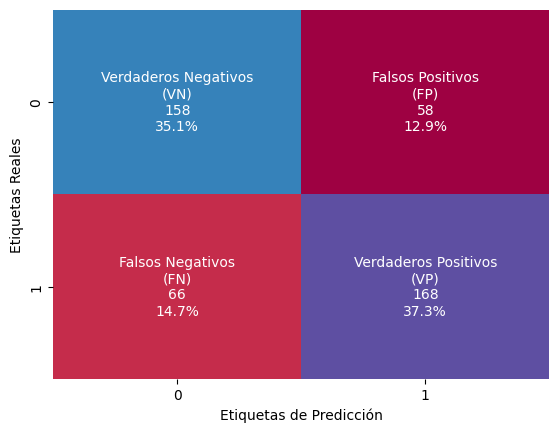

In [47]:
#Se imprimen los resultados del conjunto de prueba y las matrices de confusión para cada modelo
print('Test-accuracy con el mejor modelo de Regresión Logística: %.2f%%' % (100*final_rf_model.score(testEmb, y_test)))
pred1 = final_rf_model.predict(testEmb)
print('\nMatriz de confusión con el mejor Regresión Logística:\n')
mi_cm(y_test, pred1)

## **Mejor modelo LR**

In [40]:
print('Test-accuracy con el mejor modelo de Logistic Regression %.2f%%' % (100*final_lr_model.score(testEmb, y_test)))

pred = final_rf_model.predict(testEmb)
print('\nMatriz de confusión con el mejor modelo de Logistic Regression:')
print(confusion_matrix(y_test, pred, labels=[0,1]))

print('\nMatriz de confusión con el mejor modelo de Logistic Regression en proporciones:')
print(confusion_matrix(y_test, pred, labels=[0,1]) / pred.shape[0])

Test-accuracy con el mejor modelo de Logistic Regression 80.67%

Matriz de confusión con el mejor modelo de Logistic Regression:
[[158  58]
 [ 66 168]]

Matriz de confusión con el mejor modelo de Logistic Regression en proporciones:
[[0.35111111 0.12888889]
 [0.14666667 0.37333333]]


Test-accuracy con el mejor modelo de Regresión Logística: 80.67%

Matriz de confusión con el mejor Regresión Logística:



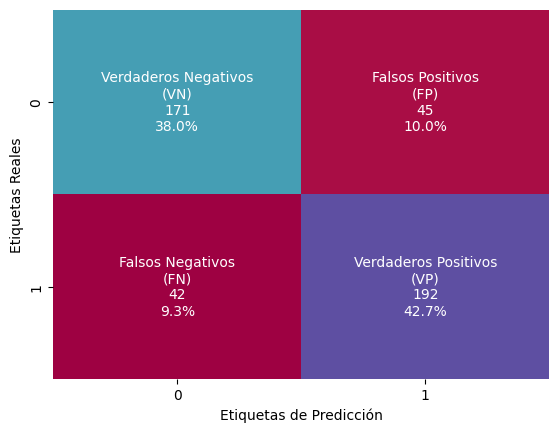

In [49]:
print('Test-accuracy con el mejor modelo de Regresión Logística: %.2f%%' % (100*final_lr_model.score(testEmb, y_test)))
pred1 = final_lr_model.predict(testEmb)
print('\nMatriz de confusión con el mejor Regresión Logística:\n')
mi_cm(y_test, pred1)

*Podemos notar que el modelo de regresión logística tuvo mejores resultados en cuanto a los valores del conjunto de pruebas, obteniendo un 80.67% de exactitud, contra un 72.44%. En cuanto a la distribución de los valores, ambos modelos tuvieron su mayor fortaleza en los Verdaderos Positivos, con un 42.7% y 37.3%, para Regresión Logística y Bosque aleatorio, respectivamente. Siguiendo con los verdaderos negativos; 38% y 35.1%. En donde existen diferencias es en el orden de los Falsos Negativos (9.3% y 14.7%) y Falsos Negativos (10% y 12.9%). Recordemos que en los "Verdaderos", más es mejor, mientras que para los "Falsos" menos es mejor. Podemos notar que hay bastante preferencia en los verdaderos de amabos modelos, por eso su exactitud es buena, sin embargo, podemos notar que acertamos más a los positivos que a los negativos, tendríamos que checar el tema de las distribuciones de los comentarios, si en el conjuntos de entrenamiento, validación y pruebaa hubo la misma cantidad de comentaraios "positivos" a los "negativos" o no, ya que eso también influye en los resultados.*


# **Pregunta 10**
Comenta con tus compañeros de equipo los pasos realizados en esta actividad e incluyan sus conclusiones finales.

# ***FALTA MODIFICAR ESTE COMENTARIO***

>>> *Agregar aquí conclusiones del trabajo*

*Dentro de la limpieza realizada se encontraron algunas validaciones que mejoraron el desempeño del modelo dado que no se procesaron ciertos valores o caracteres que no son relevantes para el estudio y alteran el resultado esperado. Posteriormente, se ejecutaron las particiones de los elementos para el desarrollo de los modelos; para ello, se acotaron los caracteres dentro del diccionario del conjunto de entrenamiento dado que se involucraron únicamente palabras relevantes las cuales tienen una mayor cantidad de frecuencia dentro de los datos.*

*Luego del preprocesamiento anterior, se inició la validación del modelo **FastText** con el fin de identificar la relación que tienen las palabras que contiene el diccionario definido. Luego de inicializarlo, se desarrollaron las funciones requeridas para obtener el promedio de los vectores y de allí otra función que transforme los documentos a vectores embebidos con el fin de asignarles valores a los vectores e identificar la correlación de cada uno entre ellos.*

*Con los procedimientos anteriores, se utilizaron dichos vectores para optimizar los modelos de Random Forest y Linear Regression, obteniendo su desempeño y la validación de estos. Detectando los hiperparámetros requeridos para cada modelo y obteniendo los resultados del desempeño de cada uno. **FastText** permite una mejor predicción dado que asigna una mejor relación entre las palabras que únicamente valores de 1 y 0 para los caracteres obtenidos, distorsionando el valor del desempeño de los modelos.*

*Para este caso, el método de transformar el corpus a sus vectores preentrenados embebidos, después de el proceso de limpieza y lematización, para después calcular el promedio de los vectores para cada comentario, resultó en una desempeño menor que el que se obtuvo para el mismo conjunto de datos y el uso de la matriz dispersa por conteo de frecuencias y de tf-idf. Con lo anterior, se pudo comprender el valor de tener cada palabra representada como un elemento de un espacio vectorial para encontrar la relación entre las palabras cercanas, sin embargo, para este caso, el uso del promedio de dichos vectores no resultó superior en exactitud a los resultados logrados con las matrices dispersas. Posiblemente, los resultados se pueden mejorar si emplea una simplificación del comentario diferente al promedio de los vectores, como lo sería un proceso de reducción tomando en cuenta la relación que tiene una palabra con otra.*



##### **Fuentes bibliográficas y de datos:**
- https://raw.githubusercontent.com/Handrum/NLP_EQ_6/main/amazon5.txt
- https://raw.githubusercontent.com/Handrum/NLP_EQ_6/main/imdb5.txt
- https://raw.githubusercontent.com/Handrum/NLP_EQ_6/main/yelp5.txt
- https://fasttext.cc/
- https://fasttext.cc/docs/en/crawl-vectors.html
- https://code.google.com/archive/p/word2vec/
- https://nlp.stanford.edu/projects/glove/
- https://medium.com/analytics-vidhya/word2vec-glove-fasttext-and-baseline-word-embeddings-step-by-step-d0489c15d10b

- Vajjala, S., Majumder, B., Gupta, A., y Surana, H. (2020). Practical Natural Language Processing: A Comprehensive Guide to Building Real-World NLP Systems. O'Reilly. https://learning.oreilly.com/library/view/practical-natural-language/9781492054047/


- Khurana, D., Koli, A., Khatter, K., y Singh, S. (2023). Natural language processing: state of the art, current trends and challenges. Multimed Tools Appl 82, 3713–3744. https://link.springer.com/article/10.1007/s11042-022-13428-4Links to an external site.

- Falcón Morales, L. E. (2023). Bolsa de palabras: BOW [PDF]. Maestría en Inteligencia Artificial Aplicada. ITESM. Acceso al material Download Acceso al material